In [1]:
%%time
import pandas as pd
import numpy as np
import collections
import pysam

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

CPU times: user 1.8 s, sys: 781 ms, total: 2.58 s
Wall time: 1min 17s


# Read in and prepare the metadata

In [2]:
metadata_df = pd.read_csv('/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/droplet-infection_3_3prime-adata-metadata.2021-02-03_modified.csv')
metadata_df

,channel,cultured,infected,culture_time,chemistry,n_counts,n_genes,predicted_doublets,viral_sense_umis,viral_antisense_umis,viral_total_umis,free_annotation,compartment,barcode,cell
0,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,1158,658,False,NaN,NaN,NaN,CD4+ Effector/Memory T,Immune,AAACCCACAATCGAAA,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
1,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,811,537,False,NaN,NaN,NaN,Capillary Aerocyte,Endothelial,AAACCCACACCCAACG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
2,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,900,550,False,NaN,NaN,NaN,General Capillary,Endothelial,AAACCCAGTGTACATC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
3,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,26740,4976,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCAGTTCGATTG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
4,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,27266,5516,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCATCATCGCTC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74895,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,2226,566,False,NaN,NaN,NaN,Dying Macrophage,Immune,TTTGTTGCATCCGGTG,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74896,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,17365,3726,False,NaN,NaN,NaN,IER3+ Macrophage,Immune,TTTGTTGGTCTACTGA,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74897,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,3301,1580,False,NaN,NaN,NaN,Alveolar Epithelial Type 1,Epithelial,TTTGTTGGTTCGAACT,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74898,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,1843,874,False,NaN,NaN,NaN,Ciliated,Epithelial,TTTGTTGTCCTTATAC,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...


In [3]:
ks = (
    metadata_df['infected'].astype(str)+'_'+
    metadata_df['culture_time'].astype(str)+'_'+
    metadata_df['barcode'].astype(str)
)

vs = (
    metadata_df['compartment'].astype(str)+'_'+
    metadata_df['free_annotation'].astype(str)
)

cell_to_type = dict(zip(ks,vs))
cell_to_type

{'False_0_AAACCCACAATCGAAA': 'Immune_CD4+ Effector/Memory T',
 'False_0_AAACCCACACCCAACG': 'Endothelial_Capillary Aerocyte',
 'False_0_AAACCCAGTGTACATC': 'Endothelial_General Capillary',
 'False_0_AAACCCAGTTCGATTG': 'Immune_Macrophage',
 'False_0_AAACCCATCATCGCTC': 'Immune_Macrophage',
 'False_0_AAACCCATCGGTCACG': 'Immune_Natural Killer T',
 'False_0_AAACGAAAGCGTCAAG': 'Immune_Macrophage',
 'False_0_AAACGAAGTATGAAAC': 'Immune_CD4+ Effector/Memory T',
 'False_0_AAACGAAGTGAGGAAA': 'Immune_Macrophage',
 'False_0_AAACGAATCGGCCTTT': 'Immune_Macrophage',
 'False_0_AAACGCTGTATGTGTC': 'Immune_CD4+ Effector/Memory T',
 'False_0_AAACGCTGTCGAACGA': 'Immune_Macrophage',
 'False_0_AAACGCTGTCGATTCA': 'Immune_Dying Macrophage',
 'False_0_AAACGCTTCACCGACG': 'Epithelial_Alveolar Epithelial Type 2',
 'False_0_AAACGCTTCGTTTACT': 'Immune_CD4+ Naive T',
 'False_0_AAAGAACAGGCATGGT': 'Endothelial_General Capillary',
 'False_0_AAAGAACCACCACTGG': 'Stromal_Alveolar Fibroblast',
 'False_0_AAAGAACCACGAGAAC': 'Epi

# Process the reads for counts per compartment/cell-type

In [4]:
#tuples of (infected,culture_time,path)
tp_paths = (
    (False,0,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/0h_noncultured_Sample_1_S1.bam'),
    (False,24,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_cultured_Sample_1_S2.bam'),
    (True,24,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_infected_Sample_1_S3.bam'),
    (True,24,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_infected_Sample_2_S4.bam'),
    (False,72,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/72h_cultured_Sample_1_S5.bam'),
    (True,72,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/72h_infected_Sample_1_S6.bam'),
    (True,72,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/72h_infected_Sample_2_S7.bam'),
    (False,96,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/96h_cultured_Sample_1_S8.bam'),
    (True,96,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/96h_infected_Sample_1_S9.bam'),
    (True,96,'/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/96h_infected_Sample_2_S10.bam'),
)


In [29]:
#Count the number of reads in Timp3 and housekeeping genes ActB and Gapdh
genes = ['Timp3','ActB','Gapdh']

gene_strands = {
    'Timp3':'+',
    'ActB':'-',
    'Gapdh':'+',
}

gene_bounds = {
    'Timp3':('chr22',32801705,32863041),
    'ActB':('chr7',5527152,5563902),
    'Gapdh':('chr12',6534517,6538371),
}

gene_counts = {
    'Timp3':collections.defaultdict(int),
    'ActB':collections.defaultdict(int),
    'Gapdh':collections.defaultdict(int),
}

for infected,culture_time,path in tp_paths:
    bam = pysam.AlignmentFile(path)
    
    for gene in genes:
        print(infected,culture_time,gene,path)
        chrom,start,end = gene_bounds[gene]
        
        for r in bam.fetch(chrom,start,end):
            if not start <= r.pos <= end:
                continue
            
            if r.is_reverse and gene_strands[gene] == '+': #skip
                continue

            if r.is_forward and gene_strands[gene] == '-': #skip
                continue

                
            _,bc,umi = r.qname.split('_')
            k = f'{infected}_{culture_time}_{bc}'

            if k not in cell_to_type:
                continue

            celltype = cell_to_type[k]

            count_k = f'{infected}_{culture_time}_{celltype}'

            gene_counts[gene][count_k] += 1
        
    
#Aggregate the gene count info
count_dfs = []
for gene in genes:
    count_df = pd.DataFrame(data={'k':gene_counts[gene].keys(),'count':gene_counts[gene].values()})
    count_df[['infected','hours','compartment','free_annotation']] = count_df['k'].str.split('_',expand=True)
    count_df.insert(0,'gene',gene)
    count_dfs.append(count_df)
    
count_df = pd.concat(count_dfs)
count_df

False 0 Timp3 /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/0h_noncultured_Sample_1_S1.bam
False 0 ActB /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/0h_noncultured_Sample_1_S1.bam
False 0 Gapdh /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/0h_noncultured_Sample_1_S1.bam
False 24 Timp3 /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_cultured_Sample_1_S2.bam
False 24 ActB /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_cultured_Sample_1_S2.bam
False 24 Gapdh /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_cultured_Sample_1_S2.bam
True 24 Timp3 /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_infected_Sample_1_S3.bam
True 24 ActB /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_infected_Sample_1_S3.bam
True 24 Gapdh /scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/24h_infected_Sample_1_S3.bam
True 24 Timp3 /scratch

,gene,k,count,infected,hours,compartment,free_annotation
0,Timp3,False_0_Stromal_Adventitial Fibroblast,979,False,0,Stromal,Adventitial Fibroblast
1,Timp3,False_0_Endothelial_General Capillary,16582,False,0,Endothelial,General Capillary
2,Timp3,False_0_Endothelial_Lymphatic,1262,False,0,Endothelial,Lymphatic
3,Timp3,False_0_Epithelial_Alveolar Epithelial Type 1,2214,False,0,Epithelial,Alveolar Epithelial Type 1
4,Timp3,False_0_Stromal_Alveolar Fibroblast,8017,False,0,Stromal,Alveolar Fibroblast
...,...,...,...,...,...,...,...
384,Gapdh,True_96_Immune_Low Quality Natural Killer/T,169,True,96,Immune,Low Quality Natural Killer/T
385,Gapdh,True_96_Stromal_Dying Fibroblast,387,True,96,Stromal,Dying Fibroblast
386,Gapdh,True_96_Stromal_Pericyte,100,True,96,Stromal,Pericyte
387,Gapdh,True_96_Stromal_Vascular Smooth Muscle,16,True,96,Stromal,Vascular Smooth Muscle


In [31]:
piv_count_df = count_df.pivot_table(
    index = ['compartment','infected','hours'],
    columns = 'gene',
    values = 'count',
    aggfunc = 'sum',
).reset_index()

piv_count_df['ActB_norm'] = piv_count_df['Timp3'].div(piv_count_df['ActB'])
piv_count_df['Gapdh_norm'] = piv_count_df['Timp3'].div(piv_count_df['Gapdh'])
piv_count_df

gene,compartment,infected,hours,ActB,Gapdh,Timp3,ActB_norm,Gapdh_norm
0,Endothelial,False,0,4923,1887,29455,5.983140,15.609433
1,Endothelial,False,24,24649,42395,6520,0.264514,0.153792
2,Endothelial,False,72,11205,31417,17989,1.605444,0.572588
3,Endothelial,False,96,18483,52867,13100,0.708759,0.247792
4,Endothelial,True,24,22062,40691,8785,0.398196,0.215895
5,Endothelial,True,72,19655,37570,16963,0.863037,0.451504
6,Endothelial,True,96,25988,67550,15684,0.603509,0.232184
7,Epithelial,False,0,8216,2118,3169,0.385711,1.496223
8,Epithelial,False,24,71106,65531,2014,0.028324,0.030734
9,Epithelial,False,72,73401,130863,26468,0.360595,0.202257


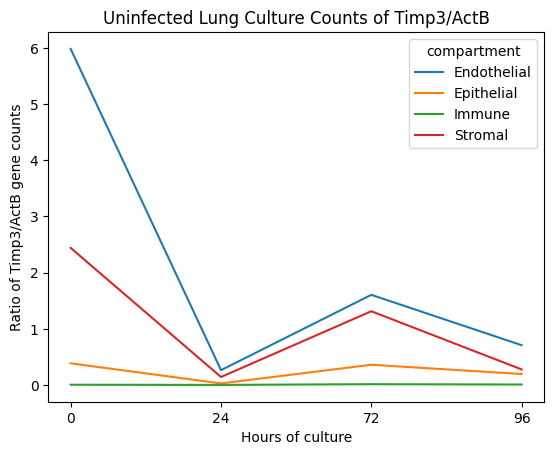

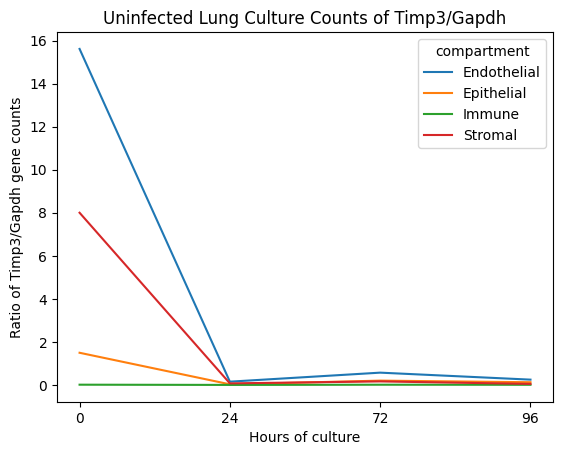

In [32]:
sns.lineplot(
    x = 'hours',
    y = 'ActB_norm',
    hue = 'compartment',
    data = piv_count_df[piv_count_df['infected'].eq('False') & piv_count_df['compartment'].ne('nan')],
)
plt.title('Uninfected Lung Culture Counts of Timp3/ActB')
plt.ylabel('Ratio of Timp3/ActB gene counts')
plt.xlabel('Hours of culture')
plt.show()
plt.close()


sns.lineplot(
    x = 'hours',
    y = 'Gapdh_norm',
    hue = 'compartment',
    data = piv_count_df[piv_count_df['infected'].eq('False') & piv_count_df['compartment'].ne('nan')],
)
plt.title('Uninfected Lung Culture Counts of Timp3/Gapdh')
plt.ylabel('Ratio of Timp3/Gapdh gene counts')
plt.xlabel('Hours of culture')
plt.show()
plt.close()

# Investigating Timp3 3' UTR in Pericytes for Greif/Jui Collaboration

In [33]:
chrom,start,end = ('chr22',32859078,32863090)

timp3_UTR_pos = collections.defaultdict(list)

for infected,culture_time,path in tp_paths:
    bam = pysam.AlignmentFile(path)
    
    for r in bam.fetch(chrom,start,end):
        if not start <= r.pos <= end:
            continue
        
        if r.is_reverse: #skip negative strand aligning reads
            continue
        
        _,bc,umi = r.qname.split('_')
        k = f'{infected}_{culture_time}_{bc}'

        #just looking for Pericytes
        if k not in cell_to_type or 'Pericyte' not in cell_to_type[k]:
            continue

        celltype = cell_to_type[k]
        count_k = f'{infected}_{culture_time}'

        timp3_UTR_pos[count_k].append(r.pos)


timp3_UTR_pos

defaultdict(list,
            {'False_0': [32859189,
              32859219,
              32859247,
              32859257,
              32859266,
              32859270,
              32859308,
              32859331,
              32859331,
              32859331,
              32859333,
              32859335,
              32859351,
              32859360,
              32859364,
              32859368,
              32859370,
              32859380,
              32859394,
              32859400,
              32859409,
              32859409,
              32859413,
              32859414,
              32859414,
              32859414,
              32859416,
              32859419,
              32859421,
              32859424,
              32859425,
              32859426,
              32859432,
              32859432,
              32859432,
              32859433,
              32859434,
              32859436,
              32859438,
              32859438,
           

In [39]:
#creating BedGraphs for plotting
bin_size = 10
min_bin = bin_size*(32859078//bin_size)
max_bin = bin_size*(32863090//bin_size)

stem = 'pericyte_covid_bedGraphs/pericyte'

for tp,ps in timp3_UTR_pos.items():
    infected = 'Infected' if 'True' in tp else 'Uninfected'
    hour = tp.split('_')[1]
    bin_counts = {b:0 for b in range(min_bin,max_bin+bin_size,bin_size)}
    for p in ps:
        bin_counts[bin_size*(p//bin_size)] += 1

    
    with open(stem+'_'+infected+'_'+hour+'hrs.bedGraph','w') as f_out:
        header = f'track type=bedGraph name="Pericyte {infected} {hour}hrs" visibility=full maxHeightPixels=50 graphType=points\n'
        f_out.write(header)
        
        for b,c in bin_counts.items():
            f_out.write(f'{chrom} {b} {b+bin_size} {c}\n')
    

In [35]:
bin_counts

{32859070: 0,
 32859080: 0,
 32859090: 0,
 32859100: 0,
 32859110: 0,
 32859120: 0,
 32859130: 0,
 32859140: 0,
 32859150: 0,
 32859160: 0,
 32859170: 0,
 32859180: 1,
 32859190: 0,
 32859200: 0,
 32859210: 1,
 32859220: 0,
 32859230: 0,
 32859240: 1,
 32859250: 1,
 32859260: 1,
 32859270: 1,
 32859280: 0,
 32859290: 0,
 32859300: 1,
 32859310: 0,
 32859320: 0,
 32859330: 5,
 32859340: 0,
 32859350: 1,
 32859360: 3,
 32859370: 1,
 32859380: 1,
 32859390: 1,
 32859400: 3,
 32859410: 6,
 32859420: 4,
 32859430: 9,
 32859440: 6,
 32859450: 8,
 32859460: 11,
 32859470: 10,
 32859480: 20,
 32859490: 15,
 32859500: 19,
 32859510: 20,
 32859520: 17,
 32859530: 26,
 32859540: 7,
 32859550: 4,
 32859560: 4,
 32859570: 4,
 32859580: 1,
 32859590: 3,
 32859600: 2,
 32859610: 2,
 32859620: 2,
 32859630: 0,
 32859640: 0,
 32859650: 0,
 32859660: 0,
 32859670: 0,
 32859680: 0,
 32859690: 0,
 32859700: 0,
 32859710: 1,
 32859720: 0,
 32859730: 0,
 32859740: 0,
 32859750: 0,
 32859760: 0,
 32859770: 0

In [26]:
max_bin

32863090

In [24]:
bin_counts

NameError: name 'bin_counts' is not defined

In [16]:
header

'track type=bedGraph name="Pericyte Uninfected 0hrs" visibility=full maxHeightPixels=50 graphType=points'

In [ ]:
max_bin

In [ ]:
bins

In [ ]:
ps

In [42]:
metadata_df

,channel,cultured,infected,culture_time,chemistry,n_counts,n_genes,predicted_doublets,viral_sense_umis,viral_antisense_umis,viral_total_umis,free_annotation,compartment,barcode,cell
0,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,1158,658,False,NaN,NaN,NaN,CD4+ Effector/Memory T,Immune,AAACCCACAATCGAAA,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
1,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,811,537,False,NaN,NaN,NaN,Capillary Aerocyte,Endothelial,AAACCCACACCCAACG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
2,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,900,550,False,NaN,NaN,NaN,General Capillary,Endothelial,AAACCCAGTGTACATC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
3,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,26740,4976,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCAGTTCGATTG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
4,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_S1,False,False,0,3prime,27266,5516,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCATCATCGCTC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74895,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,2226,566,False,NaN,NaN,NaN,Dying Macrophage,Immune,TTTGTTGCATCCGGTG,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74896,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,17365,3726,False,NaN,NaN,NaN,IER3+ Macrophage,Immune,TTTGTTGGTCTACTGA,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74897,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,3301,1580,False,NaN,NaN,NaN,Alveolar Epithelial Type 1,Epithelial,TTTGTTGGTTCGAACT,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...
74898,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8,True,False,96,3prime,1843,874,False,NaN,NaN,NaN,Ciliated,Epithelial,TTTGTTGTCCTTATAC,Covid19_Pilot2_96h_cultured_Sample_1_3prime_S8...


In [45]:
#Number of Pericyte cells per culture-time (pretty even, but definitely decreasing)
metadata_df[
    metadata_df['free_annotation'].notnull()
    & metadata_df['free_annotation'].str.contains('Pericyte')
].groupby(['culture_time','infected']).size().reset_index(name='num perictyes')

,culture_time,infected,num perictyes
0,0,False,76
1,24,False,8
2,24,True,24
3,72,False,23
4,72,True,27
5,96,False,7
6,96,True,7


In [49]:
for tp,ps in timp3_UTR_pos.items():
    infected = 'Infected' if 'True' in tp else 'Uninfected'
    hour = tp.split('_')[1]
    
    print(infected,hour,'hrs',len(ps),'reads')

Uninfected 0 hrs 545 reads
Uninfected 24 hrs 8 reads
Infected 24 hrs 10 reads
Uninfected 72 hrs 40 reads
Infected 72 hrs 33 reads
Uninfected 96 hrs 12 reads
